In [138]:
%pip install scikit-learn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [139]:
## Imports 

In [140]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import json

## Read Data

In [141]:

data_file_path = 'Dataset.csv'
data_read = pd.read_csv(data_file_path)
data_read.head()

,Unnamed: 0,vote_count,vote_average,title,tagline,status,spoken_languages,duration,revenue,release,...,production,popularity,overview,original_title,original_language,keywords,id,homepage,genres,financial_investment
0,0,11800,7.2,Avatar,Enter the World of Pandora.,Released,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",162.0,2.787965e+09,2009-12-10,...,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",150.437577,"In the 22nd century, a paraplegic Marine is di...",Avatar,en,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",19995,http://www.avatarmovie.com/,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",237000000.0
1,1,4500,6.9,Pirates of the Caribbean: At World's End,"At the end of the world, the adventure begins.",Released,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",169.0,9.610000e+08,2007-05-19,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",139.082615,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,en,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",285,http://disney.go.com/disneypictures/pirates/,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",300000000.0
2,2,4466,6.3,Spectre,A Plan No One Escapes,Released,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",148.0,8.806746e+08,2015-10-26,...,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",107.376788,A cryptic message from Bond’s past sends him o...,Spectre,en,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",206647,http://www.sonypictures.com/movies/spectre/,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",245000000.0
3,3,9106,7.6,The Dark Knight Rises,The Legend Ends,Released,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",165.0,1.084939e+09,2012-07-16,...,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",112.312950,Following the death of District Attorney Harve...,The Dark Knight Rises,en,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",49026,http://www.thedarkknightrises.com/,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",250000000.0
4,4,2124,6.1,John Carter,"Lost in our world, found in another.",Released,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",132.0,2.841391e+08,2012-03-07,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",43.926995,"John Carter is a war-weary, former military ca...",John Carter,en,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",49529,http://movies.disney.com/john-carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",260000000.0


## Treating Missing Data
Before we start building our model it is important to implement a way to treat missing values in our Dataset

In [142]:
data_read.isna().sum()

Unnamed: 0                    0
vote_count                    0
vote_average                480
title                         0
tagline                     844
status                        0
spoken_languages              0
duration                      2
revenue                      48
release                       1
countries_of_production       0
production                    0
popularity                    0
overview                      3
original_title                0
original_language           240
keywords                      0
id                            0
homepage                   3091
genres                        0
financial_investment        384
dtype: int64

From the result of the cell above we can see multiple columns have missing Data: 

**vote_average, tagline, duration, revenue, release, overview, original_language, homepage and financial_investment**

Some of those columns we will not fill in the missing values because we will drop the columns.
The data that we want to fill in our case is:

**vote_average, duration, revenue, release, original_language, financial_investment**

### Filling Release Date
We have one movie with a missing release date called **America is still the place**.

A google search tells us it was release 2022-06-10

In [143]:
# There is one missing release date. We looked it up and it is 2022-06-10
movie_title = data_read[data_read['release'].isna()]['title'].values[0]
print(movie_title)

data_read['release'] = data_read['release'].fillna('2022-06-10')

data_read['release'] = pd.to_datetime(data_read['release'])

data_read['release'].head()

America Is Still the Place


0   2009-12-10
1   2007-05-19
2   2015-10-26
3   2012-07-16
4   2012-03-07
Name: release, dtype: datetime64[ns]

### Filling Original Languages
Some of the movies were missing their original languages. To make up for that the proccess we want to use is to fill it with the first language present in the **spoken_languages** columns

In [144]:

# Loading data into json format
data_read['spoken_languages'] = data_read['spoken_languages'].apply(json.loads)



While going over the data we have found that some movies have an empty list for spoken languages. We shall deal with it at the same time as the original language

In [145]:
empty_spoken_languages = data_read[data_read['spoken_languages'].apply(lambda x: len(x) == 0)]
empty_spoken_languages.head()

,Unnamed: 0,vote_count,vote_average,title,tagline,status,spoken_languages,duration,revenue,release,...,production,popularity,overview,original_title,original_language,keywords,id,homepage,genres,financial_investment
492,492,9,5.3,Top Cat Begins,NaN,Released,[],89.0,0.0,2015-10-30,...,"[{""name"": ""Anima Estudios"", ""id"": 9965}, {""nam...",0.719996,Top Cat has arrived to charm his way into your...,Don Gato: El inicio de la pandilla,es,"[{""id"": 209714, ""name"": ""3d""}]",293644,NaN,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 16, ""nam...",NaN
1169,1169,787,6.8,42,The True Story Of An American Legend,Released,[],128.0,95020213.0,2013-04-12,...,"[{""name"": ""Warner Bros."", ""id"": 6194}]",31.884559,"The powerful story of Jackie Robinson, the leg...",42,en,"[{""id"": 1480, ""name"": ""baseball""}, {""id"": 5565...",109410,NaN,"[{""id"": 18, ""name"": ""Drama""}]",40000000.0
2590,2590,25,5.9,VeggieTales: The Pirates Who Don't Do Anything,NaN,Released,[],85.0,0.0,2008-01-11,...,"[{""name"": ""Starz Animation"", ""id"": 2885}, {""na...",1.800119,Set Sail For Adventure! A boatload of beloved ...,VeggieTales: The Pirates Who Don't Do Anything,en,"[{""id"": 380, ""name"": ""brother brother relation...",15511,NaN,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 16, ""...",0.0
2614,2614,3,4.7,The Love Letter,A letter from the past would change their futu...,Released,[],98.0,0.0,1998-02-01,...,[],0.116873,20th century computer games designer Scott exc...,The Love Letter,en,[],57943,NaN,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",0.0
2631,2631,12,7.0,The Company,NaN,Released,[],276.0,0.0,2007-08-05,...,[],1.485324,Real-life figures from the Cold War era mix wi...,The Company,en,"[{""id"": 11162, ""name"": ""miniseries""}]",112430,NaN,"[{""id"": 18, ""name"": ""Drama""}]",0.0


In [146]:
# Filling the missing values in the original_language column with the first spoken language if there is one
def get_spoken_language_of_NaN(x):
    if pd.isna(x['original_language']):
        if x['spoken_languages'].__len__() == 0:
            # If there is no spoken language, we will assume it is English
            x['original_language'] = "en"
            x['spoken_languages'] = [{'iso_639_1': 'en'}]
        else:
            x['original_language'] = x['spoken_languages'][0]['iso_639_1']
    return x
data_read = data_read.apply(get_spoken_language_of_NaN, axis=1)
data_read['original_language'].isna().sum()

0

In [147]:
# Replaced spoken_languages with the number of languages spoken
data_read['spoken_languages'] = data_read['spoken_languages'].apply(lambda x: len(x))
#Some still have missing spoken languages
data_read[data_read['spoken_languages'] == 0].head()


,Unnamed: 0,vote_count,vote_average,title,tagline,status,spoken_languages,duration,revenue,release,...,production,popularity,overview,original_title,original_language,keywords,id,homepage,genres,financial_investment
492,492,9,5.3,Top Cat Begins,NaN,Released,0,89.0,0.0,2015-10-30,...,"[{""name"": ""Anima Estudios"", ""id"": 9965}, {""nam...",0.719996,Top Cat has arrived to charm his way into your...,Don Gato: El inicio de la pandilla,es,"[{""id"": 209714, ""name"": ""3d""}]",293644,NaN,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 16, ""nam...",NaN
1169,1169,787,6.8,42,The True Story Of An American Legend,Released,0,128.0,95020213.0,2013-04-12,...,"[{""name"": ""Warner Bros."", ""id"": 6194}]",31.884559,"The powerful story of Jackie Robinson, the leg...",42,en,"[{""id"": 1480, ""name"": ""baseball""}, {""id"": 5565...",109410,NaN,"[{""id"": 18, ""name"": ""Drama""}]",40000000.0
2590,2590,25,5.9,VeggieTales: The Pirates Who Don't Do Anything,NaN,Released,0,85.0,0.0,2008-01-11,...,"[{""name"": ""Starz Animation"", ""id"": 2885}, {""na...",1.800119,Set Sail For Adventure! A boatload of beloved ...,VeggieTales: The Pirates Who Don't Do Anything,en,"[{""id"": 380, ""name"": ""brother brother relation...",15511,NaN,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 16, ""...",0.0
2614,2614,3,4.7,The Love Letter,A letter from the past would change their futu...,Released,0,98.0,0.0,1998-02-01,...,[],0.116873,20th century computer games designer Scott exc...,The Love Letter,en,[],57943,NaN,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",0.0
2631,2631,12,7.0,The Company,NaN,Released,0,276.0,0.0,2007-08-05,...,[],1.485324,Real-life figures from the Cold War era mix wi...,The Company,en,"[{""id"": 11162, ""name"": ""miniseries""}]",112430,NaN,"[{""id"": 18, ""name"": ""Drama""}]",0.0


In [148]:
data_read.loc[data_read['spoken_languages'] == 0, 'spoken_languages'] = 1
data_read[data_read['spoken_languages'] == 1].head()

,Unnamed: 0,vote_count,vote_average,title,tagline,status,spoken_languages,duration,revenue,release,...,production,popularity,overview,original_title,original_language,keywords,id,homepage,genres,financial_investment
1,1,4500,6.9,Pirates of the Caribbean: At World's End,"At the end of the world, the adventure begins.",Released,1,169.0,9.610000e+08,2007-05-19,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",139.082615,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,en,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",285,http://disney.go.com/disneypictures/pirates/,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",300000000.0
3,3,9106,7.6,The Dark Knight Rises,The Legend Ends,Released,1,165.0,1.084939e+09,2012-07-16,...,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",112.312950,Following the death of District Attorney Harve...,The Dark Knight Rises,en,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",49026,http://www.thedarkknightrises.com/,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",250000000.0
4,4,2124,6.1,John Carter,"Lost in our world, found in another.",Released,1,132.0,2.841391e+08,2012-03-07,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",43.926995,"John Carter is a war-weary, former military ca...",John Carter,en,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",49529,http://movies.disney.com/john-carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",260000000.0
6,6,3330,7.4,Tangled,They're taking adventure to new lengths.,Released,1,100.0,5.917949e+08,2010-11-24,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",48.681969,When the kingdom's most wanted-and most charmi...,Tangled,en,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",38757,http://disney.go.com/disneypictures/tangled/,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",260000000.0
7,7,6767,NaN,Avengers: Age of Ultron,A New Age Has Come.,Released,1,141.0,1.405404e+09,2015-04-22,...,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...",134.279229,When Tony Stark tries to jumpstart a dormant p...,Avengers: Age of Ultron,en,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",99861,http://marvel.com/movies/movie/193/avengers_ag...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",280000000.0


### Filling vote, duration, financial and revenue
For the vote_average and duration. We have decided to replace it with the mean.

For the investment and revenue the median was a more fitting value because some values greatly affected the mean.

The median gives us a more realistic view of where the middle of our data is but it is still not a perfect representation because it is not the actual values.
 

In [149]:
mean_investment = data_read['financial_investment'].mean()
min_investment = data_read['financial_investment'].min()
max_investment = data_read['financial_investment'].max()
median_investment = np.nanmedian(data_read['financial_investment'])
print("Median Investment: ", median_investment)
print("Mean Investment: ", mean_investment)
print("Minimum Investment: ", min_investment)
print("Maximum Investment: ", max_investment)
print("Ratio of mean to median: ", mean_investment/median_investment)

median_vote = np.nanmedian(data_read['vote_average'])
mean_vote = data_read['vote_average'].mean()
print("Median Vote: ", median_vote)
print("Mean Vote: ", mean_vote)

min_revenue = data_read['revenue'].min()
max_revenue = data_read['revenue'].max()
median_revenue = np.nanmedian(data_read['revenue'])
print("Median Revenue: ", median_revenue)
print("Mean Revenue: ", data_read['revenue'].mean())
print("Minimum Revenue: ", min_revenue)
print("Maximum Revenue: ", max_revenue)
print("Ratio of min to median: ", max_revenue/median_revenue)


Median Investment:  14800000.0
Mean Investment:  28984658.08825526
Minimum Investment:  0.0
Maximum Investment:  380000000.0
Ratio of mean to median:  1.9584228438010312
Median Vote:  6.2
Mean Vote:  6.090353920888272
Median Revenue:  19184015.0
Mean Revenue:  82314862.62060988
Minimum Revenue:  0.0
Maximum Revenue:  2787965087.0
Ratio of min to median:  145.32750766719062


In [150]:
# Replace NaN in 'vote_average' column with mean
data_read['vote_average'].fillna(data_read['vote_average'].mean(), inplace=True)

# Replace NaN in 'duration' column with mean
data_read['duration'].fillna(data_read['duration'].mean(), inplace=True)

# Replace NaN in 'financial_investment' column with median
data_read['financial_investment'].fillna(median_investment, inplace=True)

# Replace NaN in 'revenue' column with median
data_read['revenue'].fillna(median_revenue, inplace=True)

data_read.isna().sum()

Unnamed: 0                    0
vote_count                    0
vote_average                  0
title                         0
tagline                     844
status                        0
spoken_languages              0
duration                      0
revenue                       0
release                       0
countries_of_production       0
production                    0
popularity                    0
overview                      3
original_title                0
original_language             0
keywords                      0
id                            0
homepage                   3091
genres                        0
financial_investment          0
dtype: int64

## Processing the data
### Dropping columns
We mentioned before that we will be removing some columns from the dataset. First due to an intuitive analysis of the columns.

The **title, original title, the tagline and overview** provide descriptions of the content of the movie but it is difficult to extract a numerical or statistical meaning behind these.

**Countries of production** is a list of location the movies were filmed at. It is not an element that would make people go see a movie.

**Keywords** would be a great column on a bigger dataset but the amount of unique keywords compared to the number of movies in the dataset is too great. The genre column gives a more generic idea with only 20 categories.

The **id** does not mean anything

The **homepage** has too many missing values (3091 out of 4096)


In [151]:
data_read.drop(['Unnamed: 0','title', 'id', 'tagline', 'overview', 'homepage', 'keywords', 'countries_of_production', 'original_title', 'production'], axis=1, inplace=True)
data_read.head()

,vote_count,vote_average,status,spoken_languages,duration,revenue,release,popularity,original_language,genres,financial_investment
0,11800,7.2,Released,2,162.0,2.787965e+09,2009-12-10,150.437577,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",237000000.0
1,4500,6.9,Released,1,169.0,9.610000e+08,2007-05-19,139.082615,en,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",300000000.0
2,4466,6.3,Released,5,148.0,8.806746e+08,2015-10-26,107.376788,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",245000000.0
3,9106,7.6,Released,1,165.0,1.084939e+09,2012-07-16,112.312950,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",250000000.0
4,2124,6.1,Released,1,132.0,2.841391e+08,2012-03-07,43.926995,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",260000000.0


### Encoding categorical values
We have three columns we want to encode. Encoding these categorical values gives a meaningful representation to a machine learning algorithm.

Status and original_language will be one-hot encoded

Genres will be multi-label encoded

In [152]:
languages = data_read['original_language'].unique()
languages

array(['en', 'ja', 'es', 'fr', 'zh', 'ru', 'ar', 'de', 'et', 'hi', 'ko',
       'te', 'da', 'cn', 'it', 'cs', 'nl', 'ta', 'sv', 'af', 'xx', 'hu',
       'pt', 'is', 'th', 'tr', 'nb', 'pl', 'no', 'he', 'vi', 'ky', 'id',
       'ro', 'fa', 'sl', 'ps', 'el'], dtype=object)

In [153]:
# Create a new DataFrame to store the one-hot encoded languages
data_read_encoded = pd.get_dummies(data_read, columns=['original_language'])

# Now data_read_encoded contains the original DataFrame with one-hot encoded languages
data_read_encoded.columns

Index(['vote_count', 'vote_average', 'status', 'spoken_languages', 'duration',
       'revenue', 'release', 'popularity', 'genres', 'financial_investment',
       'original_language_af', 'original_language_ar', 'original_language_cn',
       'original_language_cs', 'original_language_da', 'original_language_de',
       'original_language_el', 'original_language_en', 'original_language_es',
       'original_language_et', 'original_language_fa', 'original_language_fr',
       'original_language_he', 'original_language_hi', 'original_language_hu',
       'original_language_id', 'original_language_is', 'original_language_it',
       'original_language_ja', 'original_language_ko', 'original_language_ky',
       'original_language_nb', 'original_language_nl', 'original_language_no',
       'original_language_pl', 'original_language_ps', 'original_language_pt',
       'original_language_ro', 'original_language_ru', 'original_language_sl',
       'original_language_sv', 'original_language_ta',

In [154]:
# Now to one hot encode the status column
status = data_read_encoded['status'].unique()
status

array(['Released', 'Post Production', 'Rumored'], dtype=object)

In [155]:
# Create a new DataFrame to store the one-hot encoded status
data_read_encoded = pd.get_dummies(data_read_encoded, columns=['status'])

In [156]:
# First we need to convert the genres column to a list of dictionaries
data_read_encoded['genres'] = data_read_encoded['genres'].apply(json.loads)

# Now we can extract the genres from the list of dictionaries
mlb = MultiLabelBinarizer()
def extract_genres(x):
    genres = set()
    for i in x:
        genres.add(i['name'])
    return genres

# Now we can multi-label encode the genres
encoded_genres = mlb.fit_transform(data_read_encoded['genres'].apply(extract_genres))
list(mlb.classes_)
encoded_genres_df = pd.DataFrame(encoded_genres, columns=mlb.classes_)
data_read_labeled = pd.concat([data_read_encoded, encoded_genres_df], axis=1)

# Now we can drop the genres column
data_read_labeled.drop('genres', axis=1, inplace=True)


data_read_labeled.head()

,vote_count,vote_average,spoken_languages,duration,revenue,release,popularity,financial_investment,original_language_af,original_language_ar,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,11800,7.2,2,162.0,2.787965e+09,2009-12-10,150.437577,237000000.0,False,False,...,0,0,0,0,0,1,0,0,0,0
1,4500,6.9,1,169.0,9.610000e+08,2007-05-19,139.082615,300000000.0,False,False,...,0,0,0,0,0,0,0,0,0,0
2,4466,6.3,5,148.0,8.806746e+08,2015-10-26,107.376788,245000000.0,False,False,...,0,0,0,0,0,0,0,0,0,0
3,9106,7.6,1,165.0,1.084939e+09,2012-07-16,112.312950,250000000.0,False,False,...,0,0,0,0,0,0,0,1,0,0
4,2124,6.1,1,132.0,2.841391e+08,2012-03-07,43.926995,260000000.0,False,False,...,0,0,0,0,0,1,0,0,0,0


## Correlation Analysis
Now that we have processed and encoded all our column we can analyse the relation and the impact they have with the revenue

In [157]:
corr_matrix = data_read_labeled.corr()['revenue'].sort_values(ascending=False)
print(corr_matrix.to_string())


revenue                   1.000000
vote_count                0.778124
financial_investment      0.673543
popularity                0.641186
Adventure                 0.341987
duration                  0.250013
Fantasy                   0.213573
Animation                 0.200342
Action                    0.198695
vote_average              0.188395
Family                    0.171386
Science Fiction           0.149524
original_language_en      0.094367
release                   0.090427
spoken_languages          0.086300
status_Released           0.020522
original_language_et      0.012825
War                       0.002981
original_language_te      0.001628
original_language_xx     -0.002348
original_language_ja     -0.005574
Mystery                  -0.005782
original_language_ar     -0.006155
original_language_pl     -0.006309
original_language_nb     -0.006890
original_language_vi     -0.007203
original_language_el     -0.007250
original_language_is     -0.007260
original_language_ky

First we can analyse the values that have a positive correlation with the revenue

| Feature                | Coefficient       |
|-------------------------|-------------|
| vote_count              | 0.778124    |
| financial_investment    | 0.673543    |
| popularity              | 0.641186    |
| Adventure               | 0.341987    |
| duration                | 0.250013    |
| Fantasy                 | 0.213573    |
| Animation               | 0.200342    |
| Action                  | 0.198695    |
| vote_average            | 0.188395    |
| Family                  | 0.171386    |
| Science Fiction         | 0.149524    |
| original_language_en    | 0.094367    |
| release                 | 0.090427    |
| spoken_languages        | 0.086300    |
| status_Released         | 0.020522    |
| original_language_et    | 0.012825    |
| War                     | 0.002981    |
| original_language_te    | 0.001628    |

The columns vote count, investment and popularity appear at the top. This follows our human intuition.

Some genres like **Adventure, Fantasy, Animation** and other also appear and with a relatively large correlation. This could indicate use a trend in the popular genres of movies.

Of all the original languages English shows the greatest correlation. Two possibilities on why it appears so
1. Most popular movies are made in English. English having a bigger reach across the world
2. During the processing of our dataset a lot of missing values were assigned to english as the default. This may have affected the results.

For the negative correlation, the top 10 features are as follows:
| Feature                   | Coefficient |
|---------------------------|-------------|
| Drama                     | -0.177418   |
| Horror                    | -0.081597   |
| Documentary               | -0.067741   |
| Romance                   | -0.064853   |
| original_language_fr      | -0.050359   |
| Comedy                    | -0.049146   |
| Foreign                   | -0.042286   |
| Music                     | -0.040703   |
| Crime                     | -0.039774   |
| History                   | -0.030791   |

Not many features show a great individual impact on the revenue of a movive. But the **Drama** genre show the most negative correlation  compared to other genres. The value is still small but it is interesting to see if the impact is really greater than the others.


TypeError: object of type 'numpy.float32' has no len()

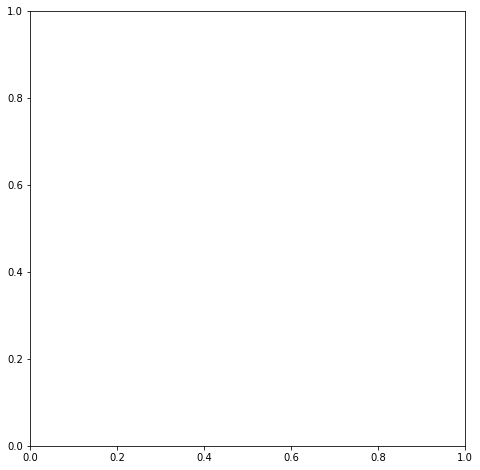

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'data_read_labeled' is your DataFrame containing multilabel columns

# Plot pie chart for each set of labels
for column_set in mlb.classes_:  # Assuming 'label_sets' contains sets of label columns
    plt.figure(figsize=(8, 8))
    labels = ['0', '1']  # Labels for 0 and 1
    sizes = data_read_labeled[column_set].sum()  # Sum of values for each label
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title(f'Pie chart of {", ".join(column_set)}')
    plt.show()


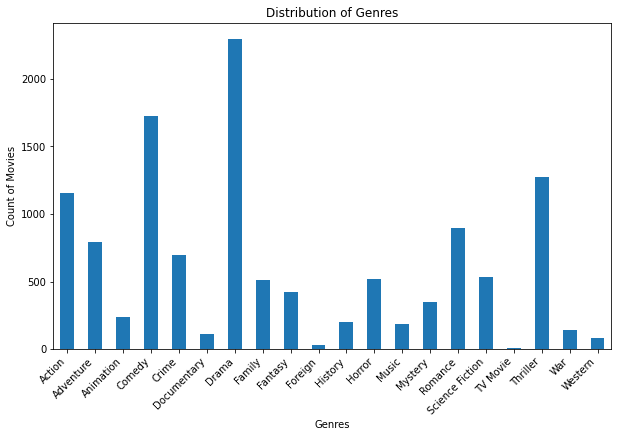

In [158]:
import matplotlib.pyplot as plt

# Assuming 'data_read_labeled' is your DataFrame containing genre columns as well as other columns
# Assuming 'available_genres' is your list of available genres

# Initialize an empty DataFrame to store genre data
genre_data = pd.DataFrame()

# Iterate over the list of available genres
for genre in mlb.classes_:
    # Check if the genre column exists in the DataFrame
    if genre in data_read_labeled.columns:
        # If the genre column exists, add it to the genre_data DataFrame
        genre_data[genre] = data_read_labeled[genre]

# Calculate the count of movies belonging to each genre
genre_counts = genre_data.sum()

# Plot the distribution of genres
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Count of Movies')
plt.title('Distribution of Genres')
plt.xticks(rotation=45, ha='right')
plt.show()


['original_language_af', 'original_language_ar', 'original_language_cn', 'original_language_cs', 'original_language_da', 'original_language_de', 'original_language_el', 'original_language_en', 'original_language_es', 'original_language_et', 'original_language_fa', 'original_language_fr', 'original_language_he', 'original_language_hi', 'original_language_hu', 'original_language_id', 'original_language_is', 'original_language_it', 'original_language_ja', 'original_language_ko', 'original_language_ky', 'original_language_nb', 'original_language_nl', 'original_language_no', 'original_language_pl', 'original_language_ps', 'original_language_pt', 'original_language_ro', 'original_language_ru', 'original_language_sl', 'original_language_sv', 'original_language_ta', 'original_language_te', 'original_language_th', 'original_language_tr', 'original_language_vi', 'original_language_xx', 'original_language_zh']


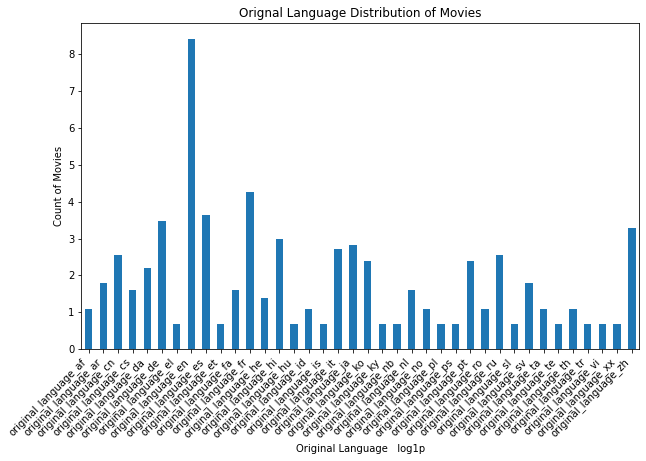

In [165]:
import matplotlib.pyplot as plt

# Assuming 'data_read_labeled' is your DataFrame containing genre columns as well as other columns
# Assuming 'available_genres' is your list of available genres

# Initialize an empty DataFrame to store genre data
genre_data = pd.DataFrame()

original_columns = ['original_language_af', 'original_language_ar', 'original_language_cn',
       'original_language_cs', 'original_language_da', 'original_language_de',
       'original_language_el', 'original_language_en', 'original_language_es',
       'original_language_et', 'original_language_fa', 'original_language_fr',
       'original_language_he', 'original_language_hi', 'original_language_hu',
       'original_language_id', 'original_language_is', 'original_language_it',
       'original_language_ja', 'original_language_ko', 'original_language_ky',
       'original_language_nb', 'original_language_nl', 'original_language_no',
       'original_language_pl', 'original_language_ps', 'original_language_pt',
       'original_language_ro', 'original_language_ru', 'original_language_sl',
       'original_language_sv', 'original_language_ta', 'original_language_te',
       'original_language_th', 'original_language_tr', 'original_language_vi',
       'original_language_xx', 'original_language_zh']
print(original_columns)

# Iterate over the list of available genres
for genre in original_columns:
    # Check if the genre column exists in the DataFrame
    if genre in data_read_labeled.columns:
        # If the genre column exists, add it to the genre_data DataFrame
        genre_data[genre] = data_read_labeled[genre]

# Calculate the count of movies belonging to each genre
genre_counts = genre_data.sum()
genre_counts = np.log1p(genre_counts)


# Plot the distribution of genres
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Original Language   log1p')
plt.ylabel('Count of Movies')
plt.title('Orignal Language Distribution of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()


In [130]:

# Define the desired range
desired_min = 0
desired_max = 6000
data_copy = data_read_labeled.copy()

# Assuming 'df' is your DataFrame with numerical features
# Initialize MinMaxScaler with the desired range
numerical_features = data_copy.select_dtypes(include=['float64', 'int64'])

scaler = MinMaxScaler(feature_range=(desired_min, desired_max))

# Fit and transform the data
scaled_features = scaler.fit_transform(numerical_features)

# Convert the scaled features back to a DataFrame (if needed)
scaled_numerical_df = pd.DataFrame(scaled_features, columns=numerical_features.columns)
scaled_df = pd.concat([data_copy.drop(columns=numerical_features.columns), scaled_numerical_df], axis=1)
scaled_df.head()


,release,original_language_af,original_language_ar,original_language_cn,original_language_cs,original_language_da,original_language_de,original_language_el,original_language_en,original_language_es,...,Thriller,War,Western,vote_count,vote_average,spoken_languages,duration,revenue,popularity,financial_investment
0,2009-12-10,False,False,False,False,False,False,False,True,False,...,0,0,0,5148.342059,4320.0,750.0,2875.739645,6000.000000,1030.887088,3742.105263
1,2007-05-19,False,False,False,False,False,False,False,True,False,...,0,0,0,1963.350785,4140.0,0.0,3000.000000,2068.175110,953.076185,4736.842105
2,2015-10-26,False,False,False,False,False,False,False,True,False,...,0,0,0,1948.516579,3780.0,3000.0,2627.218935,1895.306250,735.809141,3868.421053
3,2012-07-16,False,False,False,False,False,False,False,True,False,...,1,0,0,3972.949389,4560.0,0.0,2928.994083,2334.905349,769.634637,3947.368421
4,2012-03-07,False,False,False,False,False,False,False,True,False,...,0,0,0,926.701571,3660.0,0.0,2343.195266,611.497830,301.013702,4105.263158


## Models and Training
### Dataset Split
- 70% training
- 15% validation
- 15% test